<a href="https://colab.research.google.com/github/brandontan99/Self_Love_App/blob/brandon_ver/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [36]:
%cd /content
!git clone https://github.com/brandontan99/Self_Love_App.git
%cd /content/Self_Love_App
!pip install scikit-multilearn

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skmultilearn.adapt import *
from skmultilearn.problem_transform import *
from skmultilearn.ensemble import * 
from skmultilearn.cluster import *
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
from data_cleaning import data_cleaning
from Data_Normalization import data_encoding, data_normalization
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import time

# random seed
seed = 0

/content
fatal: destination path 'Self_Love_App' already exists and is not an empty directory.
/content/Self_Love_App


# Data Preparation

In [ ]:
# # check the "others" in the hobbies question
# valid_hobbies = ["Football","Badminton","Swimming","Jogging","Dancing","Fishing","Gardening","Playing computer games","Playing board games","Cooking","Reading","Writing","Painting","Collecting","Puzzles","Singing","Volleyball"]
# df = pd.read_csv("WID3006 ML Questionnaire.csv")
# ppl_who_chose_other_hobbies = df["What are your hobbies? (You may select more than 1)"].apply(lambda hobbies : True in [hobby.strip() not in valid_hobbies for hobby in hobbies.split(";")])
# ppl_who_chose_other_hobbies_only = df["What are your hobbies? (You may select more than 1)"].apply(lambda hobbies : np.all([hobby.strip() not in valid_hobbies for hobby in hobbies.split(";")]))
# df[ppl_who_chose_other_hobbies_only]["What are your hobbies? (You may select more than 1)"]

41                               none
58                              sleep
158                             sleep
167                          Sleeping
169    Watching anime, youtube videos
Name: What are your hobbies? (You may select more than 1), dtype: object

In [41]:
def data_normalization(df):
  # explicity min max scale because we already know the range is from 5 to 1
  df.iloc[:,50:64] = df.iloc[:,50:64].apply(lambda x: (x-1)/(5-1)) 
  return df

In [59]:
df = pd.read_csv("WID3006 ML Questionnaire.csv")
df = data_cleaning(df)
df = data_encoding(df)
df_norm = data_normalization(df)
df_norm

,Gender: _Male,What is your current occupation?_Retired,What is your current occupation?_Unemployed,What is your current occupation?_University student,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,Choose a pet which you prefer to keep._Cat,Choose a pet which you prefer to keep._Dog,Choose a pet which you prefer to keep._Fish,Choose a pet which you prefer to keep._Hamster,Choose a pet which you prefer to keep._Horse,Choose a pet which you prefer to keep._I'm not a pet person,Choose a pet which you prefer to keep._Rabbit,Choose a pet which you prefer to keep._Snake,Choose a pet which you prefer to keep._Tortoise,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,...,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,How logical of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a curious person?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,Do you enjoy making others happy?,Can you understand others' perspectives and feelings?,How confident are you in your own abilities?,Badminton,Playing computer games,Playing board games,Reading,Team sports,Exercising,Writing,Dancing,Gardening,Painting,Cooking,Singing,Puzzles,Collecting,Fishing,Watching movies,Watching TV series,Sleeping,Photography and Videography,Listening to music,Crocheting,Playing a musical instrument
0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0.75,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.75,0.75,1.00,0.75,1.00,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,

In [27]:
for i, name in enumerate(df_norm.columns):
  print(i, name)

0 Gender: _Male
1 What is your current occupation?_Retired
2 What is your current occupation?_Unemployed
3 What is your current occupation?_University student
4 What boosts your confidence ? _By leading others to success
5 What boosts your confidence ? _Get the most/ special attention among the members
6 What boosts your confidence ? _When someone acknowledges you
7 What boosts your confidence ? _When you accomplish a project
8 I prefer to spend my money on...._Food
9 I prefer to spend my money on...._Home Improvements
10 I prefer to spend my money on...._The latest fashion
11 I prefer to spend my money on...._The latest technology
12 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
13 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
14 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
15 How do you organize your thoughts? Please pick whichever is 

In [74]:
def filter_features(best_k_features, df_norm):
  return df_norm[ [column_name 
                    for column_name in df_norm.columns 
                    for question in best_k_features 
                    if column_name.startswith(question)]]

x = filter_features(best_k_features, df_norm)
x

,Gender: _Male,What boosts your confidence ? _By leading others to success,What boosts your confidence ? _Get the most/ special attention among the members,What boosts your confidence ? _When someone acknowledges you,What boosts your confidence ? _When you accomplish a project,I prefer to spend my money on...._Food,I prefer to spend my money on...._Home Improvements,I prefer to spend my money on...._The latest fashion,I prefer to spend my money on...._The latest technology,How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph,How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud,How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar,How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper,What is your favorite time of the day?_Evening,What is your favorite time of the day?_Morning,What is your favorite time of the day?_Night,Would you rather visit the future or the past?_The future,Would you rather visit the future or the past?_The past,What do you worry more about the most?_Money,What do you worry more about the most?_The state of the world,What do you worry more about the most?_Your family and friends,What do you worry more about the most?_Your future,"When you retire, you'd like to live..._Exactly where I live now","When you retire, you'd like to live..._In a hectic big city","When you retire, you'd like to live..._In a small town","When you retire, you'd like to live..._Overseas","When you retire, you'd like to live..._Traveling the world",What is your favorite color?_Blue,What is your favorite color?_Green,What is your favorite color?_Purple,What is your favorite color?_Red,What is your favorite color?_White,What is your favorite color?_Yellow,What is your learning style? (Pick one that benefit you the most)_By attending online courses,What is your learning style? (Pick one that benefit you the most)_By doing assignments,What is your learning style? (Pick one that benefit you the most)_By doing tutorial/lab questions,What is your learning style? (Pick one that benefit you the most)_By reading a physical book,What is your learning style? (Pick one that benefit you the most)_By reading an e-Book,Do you enjoy socializing with large groups of people?,Do you enjoy challenges?,How creative of a person do you think you are?,Would you prefer to engage your brain more than your body?,Are you a perfectionist?,Are you a trusting person?,Do you have lot of patience?,Do you organize your schedule well?,Do you like to sit in front of a computer for long hours?,How confident are you in your own abilities?
0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0.25,0.50,0.75,0.75,0.75,0.75,0.75,0.75,1.00,0.50
1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0.75,0.75,0.75,0.50,1.00,0.50,0.75,0.75,0.75,1.00
2,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0.25,0.75,0.75,1.00,1.00,1.00,0.50,1.00,1.00,0.75
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0.75,0.75,0.50,0.50,0.75,0.75,0.75,0.75,0.75,0.75
4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.00,0.25,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.00,1.00,0.50,0.75,0.25,0.75,0.75,0.50,0.25,0.75
188,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.50,0.25,0.50,0.50,0.25,0.50,0.75,0.75,1.00,0.75
189,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.50,0.50,0.50,0.75,0.75,0.75,0.25,0.75,0.25,0.50
190,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,

In [65]:
x = df_norm.iloc[:, :64]
y = df_norm.iloc[:, 64:]

In [ ]:
# # delete those hobbies that have less than 9 ppl choosing
# filtered_hobbies = distribution_of_hobbies[distribution_of_hobbies>=9]
# y = y[filtered_hobbies.index]
# x = x[y.sum(axis=1) != 0]
# y = y[y.sum(axis=1) != 0]

In [75]:
x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
print("Number of train dataset:", len(x_train))
print("Number of test dataset:", len(x_test))

Number of train dataset: 153
Number of test dataset: 39


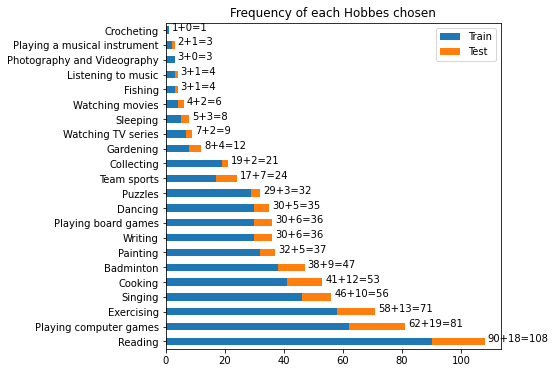

In [45]:
# draw the distribution of the hobbies with a horizontal bar chart
distribution_of_hobbies = y.sum().sort_values(ascending=False)
distribution_of_hobbies_train_test = pd.DataFrame(np.concatenate([y_train.sum(axis=0)[:,None], y_test.sum(axis=0)[:,None]], axis=1), index=y.columns, columns=["Train","Test"])
distribution_of_hobbies_train_test = distribution_of_hobbies_train_test.reindex(distribution_of_hobbies.index)
distribution_of_hobbies_train_test.plot(kind='barh', figsize=(6, 6), title="Frequency of each Hobbes chosen", stacked=True)

# put the frequency text on the right of the bar chart
for i, (row_index, row) in enumerate(distribution_of_hobbies_train_test.iterrows()):
  train_value = row["Train"]
  test_value = row["Test"]
  sum_value = train_value + test_value
  plt.text(x=sum_value+1 , y =i , s=f"{int(train_value)}+{int(test_value)}={int(sum_value)}" , fontdict=dict(fontsize=10))

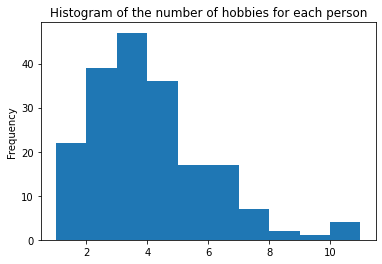

In [ ]:
y.sum(axis=1).plot.hist(title='Histogram of the number of hobbies for each person')

# Models

In [33]:
# Base Classifiers ( dict format --> (name, func) : params )
base_models = {
    ("Decision_Tree", DecisionTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Tree", ExtraTreeClassifier) : {'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'min_weight_fraction_leaf':[0.0,0.5],'random_state':[seed]},
    ("Extra_Trees", ExtraTreesClassifier) : {'n_estimators':range(90,120,10),'min_samples_split':range(2,5) , 'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("Random_Forest", RandomForestClassifier) :{'n_estimators':range(90,120,10),'min_samples_split':range(2,5),'min_samples_leaf':range(1,4),'n_jobs':[-1],'random_state':[seed]},
    ("MLP", MLPClassifier) : {'hidden_layer_sizes': [(128,64,32),(64,32),(64)],'alpha':[1e-3, 1e-2, 1e-1], 'max_iter': [2000],'random_state':[seed]},
    ("Ridge", RidgeClassifierCV) : {'fit_intercept':[True]}
}

base_models_with_errors = {
    # Error: No neighbors found for test samples array (need to increase the radius size to 20, only can run)
    ("Radius_Neighbours", RadiusNeighborsClassifier) : {'radius':[1.0,1.5,2.0],'leaf_size':range(20,40),'p':range(1,3)},
}

# Adaptation approaches
adapt_models = {
    ("Binary_Relevance_kNN_A", BRkNNaClassifier) : {'k': range(1,3)},
    ("Binary_Relevance_kNN_B", BRkNNbClassifier) : {'k': range(1,3)},
    ("Multi-Label_KNN", MLkNN) : {'k': range(1,3), 's': [0.5, 0.7, 1.0]},
    ("ARAM_Neural_Network", MLARAM) : {'threshold':[0.05], 'vigilance':[0.95]},
    ("Twin_SVM", MLTSVM) : {'c_k': [2**i for i in range(-5, 5, 2)]} # need sparse input
}

# Problem Transformation
problem_transform = {
    "Binary_Relevance" : BinaryRelevance,
    "Classifier_Chain" : ClassifierChain,
    # "Label_Powerset" : LabelPowerset # too many output because 2^20 = 1048576
}

# Ensembles of Classifiers
emsemble_methods = {
    "Distinct_Random k-labtest" : RakelD,
    "Overlapping_Random_k-labtest" : RakelO,
    "Label_Space_Partitoning" : LabelSpacePartitioningClassifier,
    "Majoity_Voting" : MajorityVotingClassifier
}
# Multi-label embeddings (KIV)

# Hyperparameters

In [34]:
# Hyperparameters Tuning
num_of_kfold_splits = 5

# Training

### Adaptation approaches

In [76]:
results = {}
scoring = 'f1_micro'
y_sparse = sparse.csr_matrix(y_train)
x_sparse = sparse.csr_matrix(x_train)
for (model_name, model), params in adapt_models.items():
  kfold = KFold(n_splits=num_of_kfold_splits, random_state=None)
  clf = GridSearchCV(model(), params, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
  if model_name == "Twin_SVM": # this model need sparse input
    clf.fit(x_sparse, y_sparse)
  else:
    clf.fit(x_train, y_train)
  results[model_name] = clf
  print(model_name,clf.best_score_)

Binary_Relevance_kNN_A 0.35886829404935977
Binary_Relevance_kNN_B 0.021010857603818368
Multi-Label_KNN 0.35886829404935977
ARAM_Neural_Network 0.3592916666328099
Twin_SVM 0.3927179107363439


### Problem Transformation

In [77]:
scoring = 'f1_micro'
x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
# Random forest and ExtraTrees takes about 20 minutes each, if dw to wait, can just comment out these 2 algo in the dict above
for strategy_name, strategy in problem_transform.items():
  for (model_name, model), params in base_models.items():
    parameters = {}
    for param_name, param_value in params.items():
      parameters["classifier__"+param_name] = param_value
    kfold = KFold(n_splits=num_of_kfold_splits, random_state=None) 
    clf = GridSearchCV(strategy(classifier=model()), parameters, cv=kfold, n_jobs=-1, scoring=scoring) # n_jobs=-1, << this cause error for some reason...
    clf.fit(x_train, y_train)
    results[f"{strategy_name}_{model_name}"] = clf
    print(f"{strategy_name}_{model_name}",clf.best_score_)

Binary_Relevance_Decision_Tree 0.3534252632945319
Binary_Relevance_Extra_Tree 0.3399555165274298
Binary_Relevance_Extra_Trees 0.35255206396136596
Binary_Relevance_Random_Forest 0.33517269688770046
Binary_Relevance_MLP 0.36696897559536845
Binary_Relevance_Ridge 0.32970676359333007
Classifier_Chain_Decision_Tree 0.34782418853159686
Classifier_Chain_Extra_Tree 0.34712886484099337
Classifier_Chain_Extra_Trees 0.3393808476010528
Classifier_Chain_Random_Forest 0.3261219589699329
Classifier_Chain_MLP 0.3491670838075314
Classifier_Chain_Ridge 0.31558067846308746


### Ensembles of Classifiers (Under reconstruction)

#### Adaptation approaches

In [ ]:
def convertToParamsForProblemTransformation(base_models):
  parameters = []
  for (model_name, model), params in base_models.items():
    parameter = {}
    parameter["classifier"] = model()
    for param_name, param_value in params.items():
      paramter["classifier__"+param_name] = param_value
    parameters.append(parameter)

  return paramters

In [ ]:
scoring = 'f1_micro'
for emsemble_name, emsemble_method in emsemble_methods.items():
  for strategy_name, strategy in problem_transform.items():
    for base_model_name, base_model in base_models.items():
      kfold = KFold(n_splits=num_of_kfold_splits, random_state=seed)
      model = strategy(
              classifier = base_model(),
              require_dense = [False, True] # depens on the data is sparse or dense
      )
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1, scoring=scoring)
      results.append(cv_results)
      names.append(model_name)
      msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
      print(msg)
      classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)

In [ ]:
classifier = MajorityVotingClassifier(
    clusterer = FixedLabelSpaceClusterer(clusters = [[1,3,4], [0, 2, 5]]),
    classifier = ClassifierChain(classifier=GaussianNB())
)
classifier.fit(X_train,y_train)


# Evaluation 

In [48]:
def display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro"):
  result_table = []
  for model_name, model in results.items():
    y_pred = model.predict(x_test)
    score = f1_score(y_test, y_pred, average=f1_average)
    score_by_class = f1_score(y_test, y_pred, average=None, zero_division=0)
    result_table.append([score]+score_by_class.tolist())

  # f1 score evaluation result overall and by class in percentage 
  # 0 means no True Positive at all or there is no example of that class in the y_text at all
  result_table_df = pd.DataFrame(result_table, columns=["Overall"]+y.columns.tolist(), index=results.keys()) * 100
  result_table_df.sort_values(by='Overall', inplace=True, ascending=False)

  # arrange the columns according to the frequency of each hobbies in the test set
  sorted_columns = distribution_of_hobbies_train_test["Test"].sort_values(ascending=False).index.tolist()
  modified_column_names = [column + "(" + str(int(distribution_of_hobbies_train_test.loc[column,"Test"]))+")" for column in sorted_columns]
  result_table_df = result_table_df[["Overall"] + sorted_columns] # sort the columns by the frequency of each hobbies in the test set 
  result_table_df.columns = [["Overall"] + modified_column_names] # add the frequency of each hobbies in the test set in the column name
  return result_table_df

display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Playing computer games(19),Reading(18),Exercising(13),Cooking(12),Singing(10),Badminton(9),Team sports(7),Writing(6),Playing board games(6),Dancing(5),Painting(5),Gardening(4),Puzzles(3),Sleeping(3),Collecting(2),Watching TV series(2),Watching movies(2),Playing a musical instrument(1),Fishing(1),Listening to music(1),Photography and Videography(0),Crocheting(0)
Binary_Relevance_Decision_Tree,34.716981,41.176471,59.459459,50.000000,20.000000,38.461538,38.095238,66.666667,14.285714,18.181818,0.000000,20.000000,0.0,0.000000,40.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_kNN_A,34.558824,54.054054,61.904762,42.857143,36.363636,33.333333,0.000000,33.333333,15.384615,33.333333,0.000000,30.769231,0.0,30.769231,28.571429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Multi-Label_KNN,34.558824,54.054054,61.904762,42.857143,36.363636,33.333333,0.000000,33.333333,15.384615,33.333333,0.000000,30.769231,0.0,30.769231,28.571429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_Decision_Tree,34.558824,36.363636,61.904762,38.461538,26.086957,37.037037,38.095238,47.058824,16.666667,40.000000,18.181818,33.333333,0.0,0.000000,28.571429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Twin_SVM,34.498834,61.538462,53.846154,47.368421,38.095238,32.432432,6.451613,47.619048,29.629630,23.076923,25.000000,10.526316,25.0,21.052632,50.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
ARAM_Neural_Network,33.812950,51.428571,60.869565,46.153846,43.478261,33.333333,0.000000,18.181818,15.384615,36.363636,0.000000,30.769231,0.0,28.571429,25.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_Extra_Trees,31.016043,33.333333,63.829787,22.222222,28.571429,40.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,50.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Extra_Tree,30.824373,46.153846,68.085106,27.272727,10.526316,30.769231,27.272727,42.857143,30.769231,0.000000,12.500000,0.000000,0.0,18.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_MLP,30.493274,43.750000,55.000000,40.000000,33.333333,31.578947,10.526316,14.285714,0.000000,25.000000,0.000000,22.222222,0.0,0.000000,50.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Ridge,29.145729,42.424242,62.222222,17.391304,14.285714,23.529412,0.000000,25.000000,0.000000,28.571429,0.000000,25.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


# Outlier Removal
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

# Feature Selection

### Chi Square Analysis
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [49]:
def sort_by_questions(data, x, ascending = False):
  question_answers_score = pd.DataFrame(data, index=x.columns).reset_index()
  question_answers_score["Question"] = question_answers_score["index"].apply(lambda column_name : column_name.split("_")[0])
  question_score = question_answers_score.groupby("Question").mean().sort_values(0, ascending=ascending)
  return question_score

def select_best_k_features(df, k=None, thres_value=None, more_than_thres_value = True ):
  if k:
    # choose the k best feature by explicitly stating the length
    best_k_features = df.index[:k].tolist()
  elif thres_value:
    # choose the k best feature by certain threshold
    if more_than_thres_value:
      best_k_features = df[df[0] > thres_value].index.tolist()
    else:
      best_k_features = df[df[0] < thres_value].index.tolist()
  
  return best_k_features

def label_encoding(data_source):
  df = pd.read_csv(data_source)
  df = df.iloc[2:,:].reset_index(drop=True) # delete first 2 responses
  df1 = df.iloc[:, 1:3]
  df2 = df.iloc[:, 18:]
  df_ranges = df.iloc[:, 4:18]
  df_categories = pd.concat([df1, df2], axis =1)
  df_categories_encoder = df_categories.apply(LabelEncoder().fit_transform)
  return pd.concat([df_categories_encoder, df_ranges], axis =1)

label_encoding_df = label_encoding("WID3006 ML Questionnaire.csv")

selected_features = [] 
x_train_label_encoded, _, y_train, _ = train_test_split(label_encoding_df.to_numpy(), y_numpy, test_size=0.2, random_state=seed)
for i in range(y_numpy.shape[1]):
    selector = SelectKBest(chi2, k='all')
    selector.fit(x_train_label_encoded, y_train[:,i])
    selected_features.append(list(selector.scores_))

# MeanCS 
selected_features = np.mean(selected_features, axis=0) 


# // MaxCS
# selected_features = np.max(selected_features, axis=0) 
# print(selected_features)
chi2_analysis = pd.DataFrame(selected_features[:,None], index=label_encoding_df.columns).sort_values(0, ascending = False)
chi2_analysis


,0
Gender:,3.005050
How do you organize your thoughts? Please pick whichever is closest.,2.354217
Choose a pet which you prefer to keep.,1.662849
What is your favorite color?,1.457257
I prefer to spend my money on....,1.082236
"When you retire, you'd like to live...",1.074117
Do you enjoy socializing with large groups of people?,0.807226
What is your learning style? (Pick one that benefit you the most),0.775461
What boosts your confidence ?,0.759482
What do you worry more about the most?,0.656682


##### Evaluation

In [50]:
# Twin SVM best number of features is 13 with 36.8 f1 score
# params = adapt_models[("Twin_SVM", MLTSVM)]
params = base_models[("Extra_Tree", ExtraTreeClassifier)]
params = {"classifier__"+param_name:param for param_name, param in params.items()}
params["classifier"] = [ExtraTreeClassifier()]
scoring = 'f1_micro'

results = {}
for i in range(len(chi2_analysis.index)):
  best_k_features = select_best_k_features(chi2_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  # y_sparse = sparse.csr_matrix(y_train)
  # x_sparse = sparse.csr_matrix(x_train)
  # clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  # clf.fit(x_sparse, y_sparse)
  clf = GridSearchCV(ClassifierChain(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.2903225806451613
Number of best k features: 2 score: 0.24043715846994534
Number of best k features: 3 score: 0.28837209302325584
Number of best k features: 4 score: 0.32061068702290074
Number of best k features: 5 score: 0.3320754716981132
Number of best k features: 6 score: 0.3282442748091603
Number of best k features: 7 score: 0.3103448275862069
Number of best k features: 8 score: 0.2720000000000001
Number of best k features: 9 score: 0.32608695652173914
Number of best k features: 10 score: 0.35036496350364965
Number of best k features: 11 score: 0.30434782608695654
Number of best k features: 12 score: 0.35125448028673834
Number of best k features: 13 score: 0.4412811387900356
Number of best k features: 14 score: 0.2916666666666667
Number of best k features: 15 score: 0.3392226148409894
Number of best k features: 16 score: 0.3161512027491409
Number of best k features: 17 score: 0.3003952569169961
Number of best k features: 18 score: 0.31654676258

In [52]:
best_k_features = select_best_k_features(chi2_analysis, k=13)
best_k_features

['Gender: ',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'Choose a pet which you prefer to keep.',
 'What is your favorite color?',
 'I prefer to spend my money on....',
 "When you retire, you'd like to live...",
 'Do you enjoy socializing with large groups of people?',
 'What is your learning style? (Pick one that benefit you the most)',
 'What boosts your confidence ? ',
 'What do you worry more about the most?',
 'Do you like to sit in front of a computer for long hours?',
 'Do you have lot of patience?',
 'Would you rather visit the future or the past?']

In [57]:
# 13 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Playing computer games(19),Reading(18),Exercising(13),Cooking(12),Singing(10),Badminton(9),Team sports(7),Writing(6),Playing board games(6),Dancing(5),Painting(5),Gardening(4),Puzzles(3),Sleeping(3),Collecting(2),Watching TV series(2),Watching movies(2),Playing a musical instrument(1),Fishing(1),Listening to music(1),Photography and Videography(0),Crocheting(0)
Classifier_Chain_Extra_Tree,44.128114,57.142857,69.767442,51.851852,66.666667,33.333333,36.363636,60.000000,36.363636,40.000000,0.000000,22.222222,0.000000,22.222222,28.571429,0.0,0.000000,66.666667,0.0,0.0,0.000000,0.0,0.0
Twin_SVM,36.812144,66.666667,64.285714,46.511628,43.478261,37.209302,17.647059,46.153846,32.258065,20.000000,20.000000,22.222222,37.500000,25.000000,20.000000,0.0,23.529412,0.000000,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_kNN_A,35.460993,54.054054,62.222222,34.782609,32.000000,45.454545,11.764706,46.153846,40.000000,14.285714,0.000000,33.333333,0.000000,16.666667,28.571429,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Multi-Label_KNN,35.460993,54.054054,62.222222,34.782609,32.000000,45.454545,11.764706,46.153846,40.000000,14.285714,0.000000,33.333333,0.000000,16.666667,28.571429,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_Extra_Trees,35.406699,50.000000,63.636364,50.000000,15.384615,37.500000,0.000000,25.000000,0.000000,20.000000,0.000000,28.571429,0.000000,0.000000,33.333333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
ARAM_Neural_Network,35.251799,59.459459,62.222222,32.000000,25.000000,45.454545,12.500000,33.333333,42.857143,15.384615,0.000000,35.294118,0.000000,16.666667,28.571429,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_MLP,34.666667,57.142857,57.142857,37.037037,23.529412,30.000000,0.000000,20.000000,36.363636,22.222222,28.571429,25.000000,0.000000,0.000000,50.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Decision_Tree,32.974910,43.750000,55.813953,50.000000,42.105263,33.333333,10.526316,61.538462,26.666667,14.285714,0.000000,16.666667,28.571429,0.000000,40.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_MLP,32.500000,51.428571,54.545455,38.709677,21.052632,40.000000,0.000000,20.000000,16.666667,20.000000,28.571429,20.000000,0.000000,0.000000,50.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Extra_Tree,31.501832,51.428571,60.000000,24.000000,25.000000,36.363636,36.363636,25.000000,25.000000,23.529412,0.000000,0.000000,0.000000,40.000000,33.333333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


### Recursive Feature Elimination (rfe)
https://machinelearningmastery.com/rfe-feature-selection-in-python/

Badminton 44
1 Gender: _Male
2 What is your current occupation?_Retired
3 What is your current occupation?_Unemployed
4 What is your current occupation?_University student
5 What boosts your confidence ? _By leading others to success
6 What boosts your confidence ? _Get the most/ special attention among the members
9 I prefer to spend my money on...._Food
10 I prefer to spend my money on...._Home Improvements
11 I prefer to spend my money on...._The latest fashion
12 I prefer to spend my money on...._The latest technology
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
17 Choose a pet which you prefer to keep._Cat
18 Choose a pet which you prefer to keep._Dog
21 Choose a pet which you prefer to keep._Horse
22 Choose a pet which you prefer to keep._I'm not a pet person
25 Choose a pet which you prefer to keep._Tortoise
27 What is you

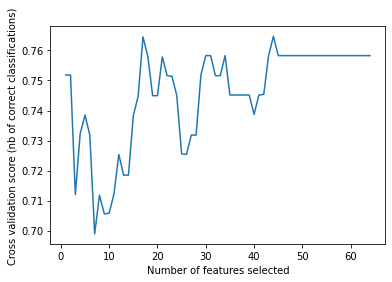

Playing computer games 28
1 Gender: _Male
4 What is your current occupation?_University student
5 What boosts your confidence ? _By leading others to success
10 I prefer to spend my money on...._Home Improvements
11 I prefer to spend my money on...._The latest fashion
12 I prefer to spend my money on...._The latest technology
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
18 Choose a pet which you prefer to keep._Dog
22 Choose a pet which you prefer to keep._I'm not a pet person
23 Choose a pet which you prefer to keep._Rabbit
24 Choose a pet which you prefer to keep._Snake
34 What do you worry more about the most?_Your future
35 When you retire, you'd like to live..._Exactly where I live now
39 When you retire, you'd like to li

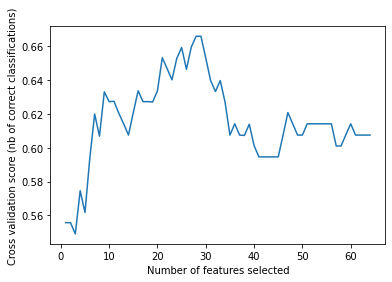

Playing board games 1
57 Are you a perfectionist?


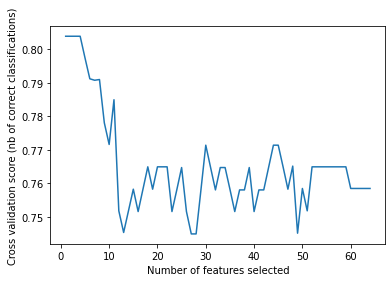

Reading 17
1 Gender: _Male
6 What boosts your confidence ? _Get the most/ special attention among the members
7 What boosts your confidence ? _When someone acknowledges you
8 What boosts your confidence ? _When you accomplish a project
17 Choose a pet which you prefer to keep._Cat
24 Choose a pet which you prefer to keep._Snake
27 What is your favorite time of the day?_Morning
31 What do you worry more about the most?_Money
33 What do you worry more about the most?_Your family and friends
36 When you retire, you'd like to live..._In a hectic big city
43 What is your favorite color?_Red
44 What is your favorite color?_White
50 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
51 Do you enjoy socializing with large groups of people?
52 Do you enjoy challenges?
53 How creative of a person do you think you are?
56 Are you a curious person?


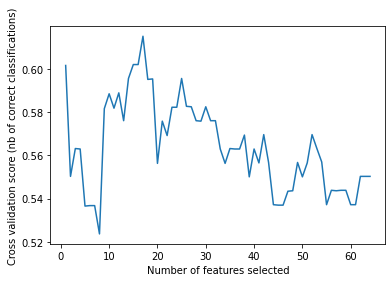

Team sports 1
1 Gender: _Male


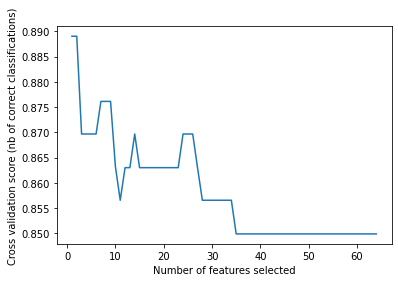

Exercising 6
17 Choose a pet which you prefer to keep._Cat
21 Choose a pet which you prefer to keep._Horse
45 What is your favorite color?_Yellow
50 What is your learning style? (Pick one that benefit you the most)_By reading an e-Book
55 Would you prefer to engage your brain more than your body?
64 How confident are you in your own abilities?


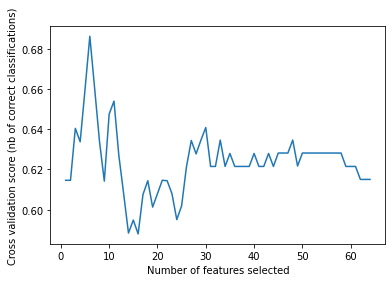

Writing 5
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
19 Choose a pet which you prefer to keep._Fish
35 When you retire, you'd like to live..._Exactly where I live now
53 How creative of a person do you think you are?
60 Do you organize your schedule well?


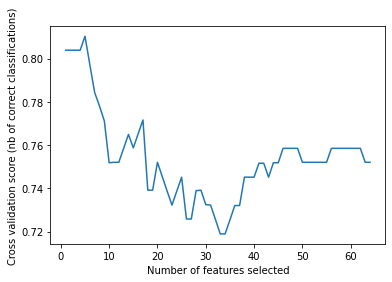

Dancing 38
1 Gender: _Male
4 What is your current occupation?_University student
5 What boosts your confidence ? _By leading others to success
7 What boosts your confidence ? _When someone acknowledges you
8 What boosts your confidence ? _When you accomplish a project
10 I prefer to spend my money on...._Home Improvements
13 How do you organize your thoughts? Please pick whichever is closest._I make a chart or graph
14 How do you organize your thoughts? Please pick whichever is closest._I talk to myself out loud
15 How do you organize your thoughts? Please pick whichever is closest._I write it down in my calendar
16 How do you organize your thoughts? Please pick whichever is closest._Jotting it down on a scrap of paper
18 Choose a pet which you prefer to keep._Dog
25 Choose a pet which you prefer to keep._Tortoise
26 What is your favorite time of the day?_Evening
27 What is your favorite time of the day?_Morning
29 Would you rather visit the future or the past?_The future
30 Would you 

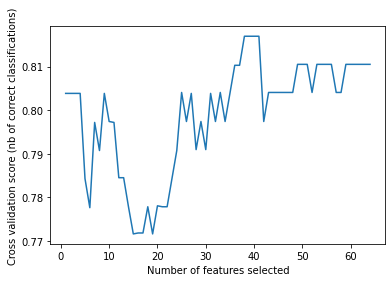

Gardening 1
59 Do you have lot of patience?


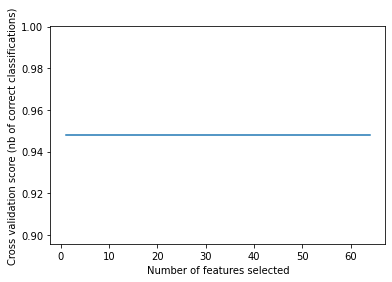

Painting 7
1 Gender: _Male
4 What is your current occupation?_University student
8 What boosts your confidence ? _When you accomplish a project
42 What is your favorite color?_Purple
47 What is your learning style? (Pick one that benefit you the most)_By doing assignments
53 How creative of a person do you think you are?
54 How logical of a person do you think you are?


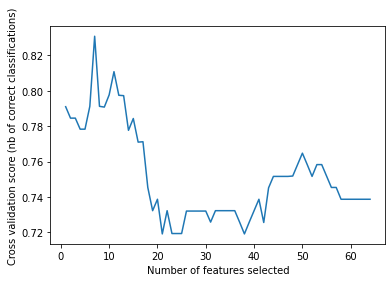

Cooking 5
10 I prefer to spend my money on...._Home Improvements
43 What is your favorite color?_Red
44 What is your favorite color?_White
51 Do you enjoy socializing with large groups of people?
52 Do you enjoy challenges?


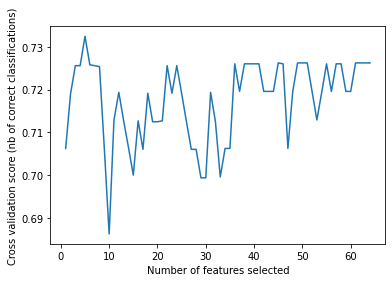

Singing 1
36 When you retire, you'd like to live..._In a hectic big city


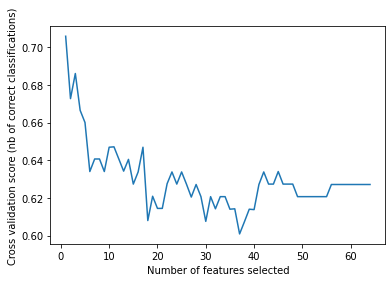

Puzzles 1
33 What do you worry more about the most?_Your family and friends


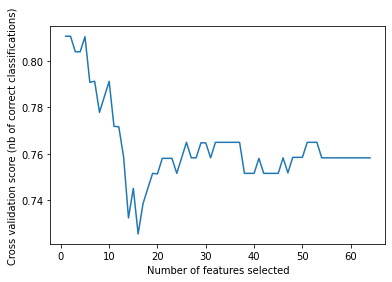

21 Choose a pet which you prefer to keep._Horse


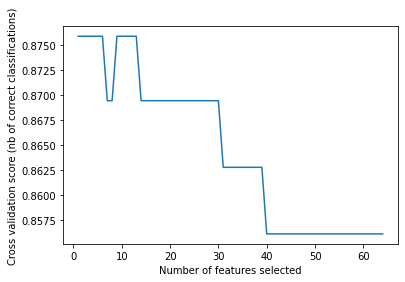

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fishing 1
22 Choose a pet which you prefer to keep._I'm not a pet person


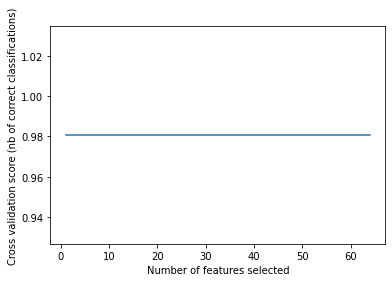

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Watching movies 1
31 What do you worry more about the most?_Money


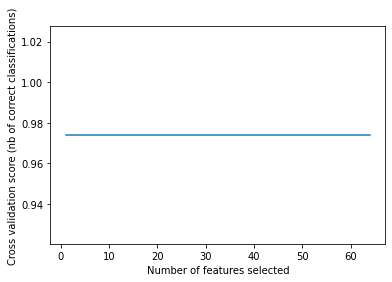

Watching TV series 1
43 What is your favorite color?_Red


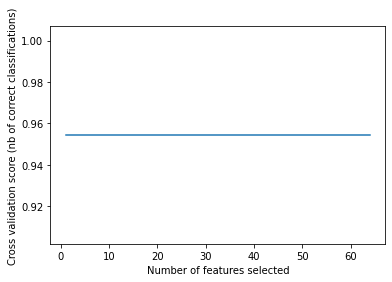

Sleeping 1
34 What do you worry more about the most?_Your future


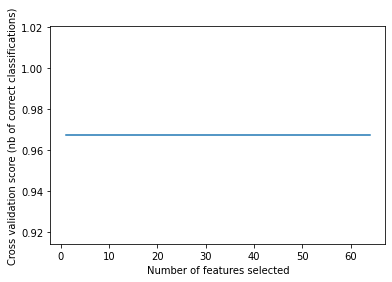

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Photography and Videography 1
21 Choose a pet which you prefer to keep._Horse


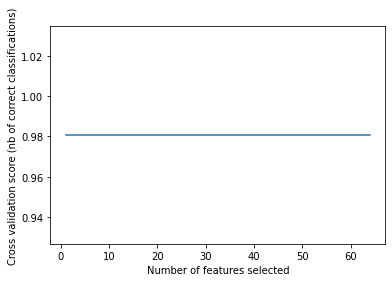

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Listening to music 1
27 What is your favorite time of the day?_Morning


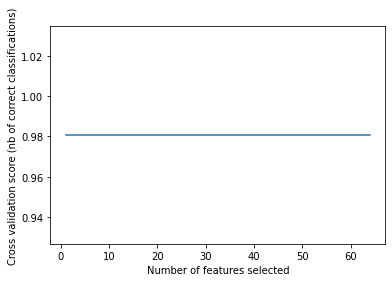

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: ignored

In [62]:
scoring = 'f1_micro'
min_features_to_select=1
rfecv_by_class = []

for i in range(y_train.shape[1]):
  model = LogisticRegression()
  rfecv = RFECV(model, step=1, cv=5, min_features_to_select=min_features_to_select, scoring=scoring)
  rfecv.fit(x_train, y_train[:,i])
  rfecv_by_class.append(rfecv.ranking_)
  print(y.columns[i], rfecv.n_features_)
  for i in range(len(x.columns)): 
    if rfecv.support_[i]:
      print(i+1, x.columns[i])

# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# selected_features = np.mean(selected_features, axis=0)
# print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

rfecv_by_class = np.array(rfecv_by_class)  

##### Evaluation

In [72]:
rfe_analysis = sort_by_questions(np.mean(rfecv_by_class, axis=0), x, ascending=True) 
params = adapt_models[("Twin_SVM", MLTSVM)]
scoring = 'f1_micro'

results = {}
for i in range(len(rfe_analysis.index)):
  best_k_features = select_best_k_features(rfe_analysis, k=i+1)
  x = filter_features(best_k_features, df_norm)
  x_numpy, y_numpy = x.to_numpy(), y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(x_numpy, y_numpy, test_size=0.2, random_state=seed)
  y_sparse = sparse.csr_matrix(y_train)
  x_sparse = sparse.csr_matrix(x_train)
  clf = GridSearchCV(MLTSVM(), params, cv=5, n_jobs=-1, scoring=scoring)
  clf.fit(x_sparse, y_sparse)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  print("Number of best k features:", len(best_k_features), "score:",score)

Number of best k features: 1 score: 0.32581453634085217
Number of best k features: 2 score: 0.31560891938250424
Number of best k features: 3 score: 0.2847222222222222
Number of best k features: 4 score: 0.28772919605077574
Number of best k features: 5 score: 0.2932692307692307
Number of best k features: 6 score: 0.306547619047619
Number of best k features: 7 score: 0.30569105691056914
Number of best k features: 8 score: 0.32646592709984157
Number of best k features: 9 score: 0.3237518910741301
Number of best k features: 10 score: 0.34615384615384615
Number of best k features: 11 score: 0.3369397217928903
Number of best k features: 12 score: 0.34353741496598633
Number of best k features: 13 score: 0.34840871021775544
Number of best k features: 14 score: 0.33333333333333337
Number of best k features: 15 score: 0.3478260869565218
Number of best k features: 16 score: 0.3346613545816733
Number of best k features: 17 score: 0.3512974051896208
Number of best k features: 18 score: 0.3405940594

In [73]:
best_k_features = select_best_k_features(rfe_analysis, k=20)
best_k_features

['Gender: ',
 'Do you enjoy challenges?',
 'Are you a trusting person?',
 'Would you rather visit the future or the past?',
 'How do you organize your thoughts? Please pick whichever is closest.',
 'What do you worry more about the most?',
 'How creative of a person do you think you are?',
 'Do you have lot of patience?',
 'How confident are you in your own abilities?',
 'What is your favorite color?',
 "When you retire, you'd like to live...",
 'Are you a perfectionist?',
 'Do you enjoy socializing with large groups of people?',
 'Do you like to sit in front of a computer for long hours?',
 'What is your favorite time of the day?',
 'What is your learning style? (Pick one that benefit you the most)',
 'I prefer to spend my money on....',
 'Do you organize your schedule well?',
 'What boosts your confidence ? ',
 'Would you prefer to engage your brain more than your body?']

In [78]:
# 20 features
display_evaluation_result(results, y, x_test, y_test, distribution_of_hobbies_train_test, f1_average = "micro")

,Overall,Playing computer games(19),Reading(18),Exercising(13),Cooking(12),Singing(10),Badminton(9),Team sports(7),Writing(6),Playing board games(6),Dancing(5),Painting(5),Gardening(4),Puzzles(3),Sleeping(3),Collecting(2),Watching TV series(2),Watching movies(2),Playing a musical instrument(1),Fishing(1),Listening to music(1),Photography and Videography(0),Crocheting(0)
Classifier_Chain_Extra_Tree,37.762238,46.153846,52.380952,51.612903,54.545455,26.086957,22.222222,61.538462,26.666667,44.444444,20.000000,14.285714,0.000000,36.363636,0.000000,0.0,0.000000,0.0,0.0,0.0,40.000000,0.0,0.0
Twin_SVM,37.021277,62.962963,61.538462,46.511628,48.888889,30.769231,27.027027,47.619048,28.571429,31.250000,25.000000,8.695652,22.222222,18.181818,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_Decision_Tree,36.496350,42.424242,54.545455,60.000000,21.052632,25.000000,36.363636,53.333333,36.363636,66.666667,20.000000,26.666667,0.000000,0.000000,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Decision_Tree,33.582090,42.424242,51.428571,40.000000,36.363636,37.037037,34.782609,57.142857,36.363636,30.769231,0.000000,26.666667,0.000000,0.000000,0.000000,0.0,22.222222,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_MLP,32.456140,56.410256,52.380952,32.000000,14.285714,38.095238,11.764706,18.181818,0.000000,22.222222,0.000000,40.000000,0.000000,28.571429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_Extra_Tree,31.799163,35.294118,63.157895,35.714286,28.571429,50.000000,37.500000,20.000000,16.666667,14.285714,0.000000,22.222222,0.000000,33.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Classifier_Chain_MLP,31.279621,41.176471,48.780488,43.478261,26.666667,37.500000,16.666667,16.666667,0.000000,20.000000,0.000000,25.000000,0.000000,33.333333,50.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Binary_Relevance_kNN_A,31.250000,40.000000,60.000000,26.086957,28.571429,47.619048,23.529412,18.181818,18.181818,18.181818,0.000000,33.333333,0.000000,33.333333,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Multi-Label_KNN,31.250000,40.000000,60.000000,26.086957,28.571429,47.619048,23.529412,18.181818,18.181818,18.181818,0.000000,33.333333,0.000000,33.333333,28.571429,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
ARAM_Neural_Network,28.996283,37.837838,53.658537,30.769231,18.181818,47.619048,10.526316,36.363636,15.384615,0.000000,15.384615,30.769231,0.000000,33.333333,33.333333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


# Save and load model
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))